In [1]:
import h5py
import numpy as np
import tensorflow as tf 
import keras
from keras.layers import Input, Conv2D, Activation, MaxPooling2D, Flatten, Dropout, Dense, concatenate, BatchNormalization
from keras.models import Model
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def splitSamples(data, label, train_size):
    unique_classes = np.unique(label)  #获取唯一的类别标签
    precentage = train_size
    
    trainData = []
    trainLabel = []
    testData = []
    testLabel = []

    for i in unique_classes:
        index = np.where(label == i)[0]
        np.random.shuffle(index)
        num_train = int(precentage * len(index))    #使用int得到截断值
        index_train = index[:num_train]
        index_test = index[num_train:]

        trainData.extend(data[index_train, :])
        trainLabel.extend(label[index_train])
        testData.extend(data[index_test, :])
        testLabel.extend(label[index_test])
    
    trainData = np.array(trainData)
    trainLabel = np.array(trainLabel).reshape(-1, 1)
    testData = np.array(testData)
    testLabel = np.array(testLabel).reshape(-1, 1)

    return trainData, trainLabel, testData, testLabel

In [3]:
import h5py
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import time 

#导入之前得到的图像数据
file = h5py.File('DB2_S1_image_200_0.h5','r')
imageData   = file['imageData'][:]
imageLabel  = file['imageLabel'][:]
file.close()

#将数据和标签分割成测试集和训练集
trainData, trainLabel, testData, testLabel = splitSamples(imageData, imageLabel, train_size=0.8)
#对数据升维
trainData = np.expand_dims(trainData,axis=3)
testData = np.expand_dims(testData,axis=3)

#将训练集和测试集的标签转为独热编码one-hot
trainLabel = tf.keras.utils.to_categorical(trainLabel)
testLabel = tf.keras.utils.to_categorical(testLabel)

In [4]:
from keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D
from keras.layers import LSTM
from keras.layers import Reshape
from keras.layers import Bidirectional

def cnn_block(x, filters,kernel_size,pool_size):
    # 卷积层
    x = Conv2D(filters, kernel_size=kernel_size, padding='same')(x)
    # 批量归一化
    x = BatchNormalization()(x)
    # ReLU 激活函数
    x = ReLU()(x)
    # 最大池化层
    x = MaxPooling2D(pool_size=pool_size)(x)
    return x

input_layer3 = Input((200,12,1))
# 第一个重复块
x3 = cnn_block(input_layer3, filters=32, kernel_size=(2,2), pool_size=(2,2))
# 第二个重复块
x3 = cnn_block(x3, filters=64, kernel_size=(3,3), pool_size=(2,2))
# 第三个重复块
x3 = cnn_block(x3, filters=128, kernel_size=(5,5), pool_size=(2,2))
# 第四个重复块
x3 = cnn_block(x3, filters=256, kernel_size=(7,7), pool_size=(1,1))
# 添加展平层
x3 = Flatten()(x3)

# 调整形状
reshape3 = Reshape((25,256))(x3)
#lstm = LSTM(64, return_sequences=False)(reshape)
lstm3 = Bidirectional(LSTM(128, return_sequences=False))(reshape3)
lstm3 = Dropout(0.5)(lstm3)
output_layer3 = Dense(128,activation = 'relu')(lstm3)
# 全连接图层
output_layer3 = Dropout(0.3)(output_layer3)
output_layer3 = Dense(49, activation = 'softmax')(output_layer3)
model4 = Model(inputs=input_layer3, outputs=output_layer3)
model4.summary()
import time
model4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
start_time = time.time()

# 训练模型
'''model参数：
verbose————日志显示模式，0 表示不在标准输出流输出日志信息，
                     1 表示输出进度条记录，
                     2 表示每个 epoch 输出一行记录。'''
history4 = model4.fit(trainData, trainLabel, epochs=300, batch_size=64)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 12, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 200, 12, 32)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 200, 12, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 200, 12, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 100, 6, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 6, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100, 6, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 100, 6, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 50, 3, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 3, 128)     │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 50, 3, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 50, 3, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 25, 1, 256)     │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 25, 1, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 25, 1, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 25, 1, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 25, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             

 Total params: 2,264,849 (8.64 MB)

 Trainable params: 2,263,889 (8.64 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/300
149/149 ━━━━━━━━━━━━━━━━━━━━ 34s 141ms/step - accuracy: 0.0902 - loss: 3.5106
Epoch 2/300
149/149 ━━━━━━━━━━━━━━━━━━━━ 27s 182ms/step - accuracy: 0.2604 - loss: 2.5018
Epoch 3/300
149/149 ━━━━━━━━━━━━━━━━━━━━ 29s 193ms/step - accuracy: 0.3699 - loss: 2.0631
Epoch 4/300
149/149 ━━━━━━━━━━━━━━━━━━━━ 30s 201ms/step - accuracy: 0.4314 - loss: 1.8563
Epoch 5/300
149/149 ━━━━━━━━━━━━━━━━━━━━ 40s 193ms/step - accuracy: 0.4865 - loss: 1.6992
Epoch 6/300
149/149 ━━━━━━━━━━━━━━━━━━━━ 30s 198ms/step - accuracy: 0.5087 - loss: 1.5696
Epoch 7/300
149/149 ━━━━━━━━━━━━━━━━━━━━ 28s 189ms/step - accuracy: 0.5325 - loss: 1.4967
Epoch 8/300
149/149 ━━━━━━━━━━━━━━━━━━━━ 25s 168ms/step - accuracy: 0.5710 - loss: 1.3651
Epoch 9/300
149/149 ━━━━━━━━━━━━━━━━━━━━ 30s 203ms/step - accuracy: 0.5939 - loss: 1.2847
Epoch 10/300
149/149 ━━━━━━━━━━━━━━━━━━━━ 31s 210ms/step - accuracy: 0.6109 - loss: 1.2279
Epoch 11/300
149/149 ━━━━━━━━━━━━━━━━━━━━ 28s 187ms/step - accuracy: 0.6295 - loss: 1.1531
Epoch 12

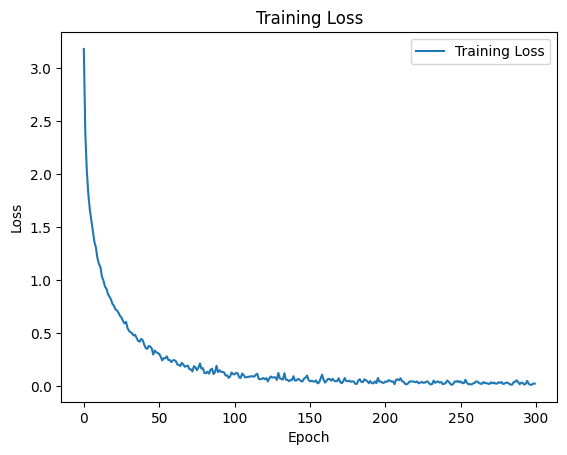

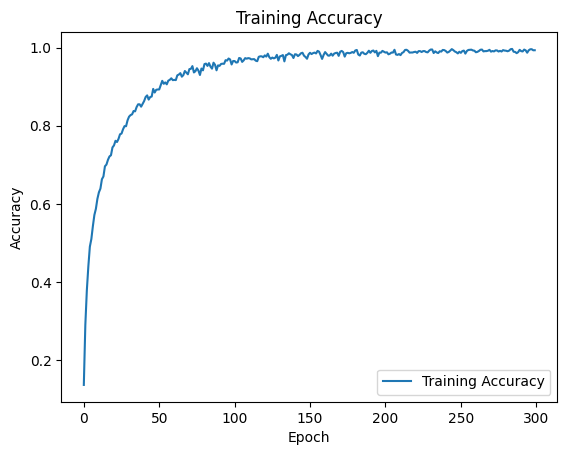

298/298 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9995 - loss: 0.0027
Train accuracy: 0.9995793700218201
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7682 - loss: 1.8734
Test Loss = 1.7420531511306763
Test Accuracy = 0.78087317943573
训练模型花费的时间: 6156.60 秒


In [5]:
# 绘制训练损失和验证损失曲线
plt.plot(history4.history['loss'], label='Training Loss')
#plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 绘制训练准确率和验证准确率曲线
plt.plot(history4.history['accuracy'], label='Training Accuracy')
#plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 评估模型
train_loss4, train_acc4 = model4.evaluate(trainData, trainLabel)
print('Train accuracy:', train_acc4)

# 使用模型进行预测
predictions4 = model4.evaluate(testData, testLabel)
print("Test Loss = " + str(predictions4[0]))
print("Test Accuracy = " + str(predictions4[1]))
print('训练模型花费的时间: %.2f 秒' % (time.time() - start_time))

In [6]:
import json

# 训练模型
# 将 history 转换为字典
history_dict = history4.history

# 保存为 JSON 文件
with open('history2-s1.json', 'w') as json_file:
    json.dump(history_dict, json_file)